In [18]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model
from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models
from simtrain.Dataset import CustomDataset
from simtrain.train import train

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ast

import paths
from os.path import join
import pytorch_warmup as warmup


In [2]:
num_items = 7
num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
num_users = 11
min_inter = 2
max_inter = 4
state_size = SETTINGS.STATE_SIZE
experiment_name = "testing2"

In [3]:
'''
# generate toy data
data = []
for user in range(num_users):
    num_interactions_now = random.randint(a=min_inter, b=max_inter)
    new = {
        'item_ids': torch.randint(low=1, high=num_items, size=(num_interactions_now, 
        num_items_per_recom, recom_dim)).to(torch.float32),
        'timestamps': torch.sort(torch.FloatTensor(num_interactions_now).uniform_(0, 1.))[0].to(torch.float32),
        'interaction_types': torch.randint(low=0, high=num_interaction_types-1, 
        size=(num_interactions_now, num_items_per_recom)),
        "user_means": torch.randn((state_size), requires_grad=True).to(torch.float32),
        "user_vars_log": torch.randn((state_size), requires_grad=True).to(torch.float32),
    }
    data.append(new)


# Create the dataset
dataset = CustomDataset(data)

# Example usage with DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1
'''


'\n# generate toy data\ndata = []\nfor user in range(num_users):\n    num_interactions_now = random.randint(a=min_inter, b=max_inter)\n    new = {\n        \'item_ids\': torch.randint(low=1, high=num_items, size=(num_interactions_now, \n        num_items_per_recom, recom_dim)).to(torch.float32),\n        \'timestamps\': torch.sort(torch.FloatTensor(num_interactions_now).uniform_(0, 1.))[0].to(torch.float32),\n        \'interaction_types\': torch.randint(low=0, high=num_interaction_types-1, \n        size=(num_interactions_now, num_items_per_recom)),\n        "user_means": torch.randn((state_size), requires_grad=True).to(torch.float32),\n        "user_vars_log": torch.randn((state_size), requires_grad=True).to(torch.float32),\n    }\n    data.append(new)\n\n\n# Create the dataset\ndataset = CustomDataset(data)\n\n# Example usage with DataLoader\ndataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1\n'

In [4]:
#create dataset from processed data
'''
train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

print(stg)

def convert_string_to_double_list(s):
    return ast.literal_eval(s)

# Apply the custom function
train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

print("len: ", len(train_dat))
list_of_dicts = train_dat.to_dict(orient='records')

train_dat.head()

'''

'\ntrain_dat, stg = process_dat.load_dat(paths.cw_stages[\'output_new\'][\'train\'], new_data=True)\n\nprint(stg)\n\ndef convert_string_to_double_list(s):\n    return ast.literal_eval(s)\n\n# Apply the custom function\ntrain_dat[\'item_ids\'] = train_dat[\'item_ids\'].apply(convert_string_to_double_list)\ntrain_dat[\'user_means\'] = train_dat[\'user_means\'].apply(convert_string_to_double_list)\ntrain_dat[\'user_vars_log\'] = train_dat[\'user_vars_log\'].apply(convert_string_to_double_list)\ntrain_dat[\'timestamps\'] = train_dat[\'timestamps\'].apply(convert_string_to_double_list)\ntrain_dat[\'interaction_types\'] = train_dat[\'interaction_types\'].apply(convert_string_to_double_list)\n\nprint("len: ", len(train_dat))\nlist_of_dicts = train_dat.to_dict(orient=\'records\')\n\ntrain_dat.head()\n\n'

In [5]:

checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5"))
list_of_dicts = checkpoint['data']

In [6]:

dataset = CustomDataset(list_of_dicts[:50])
# Example usage with DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [7]:
def test_timestamps(dataloader):
    smallest = float("inf")
    biggest = -1
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
    print(smallest), print(biggest)
    return biggest

max_time = test_timestamps(dataloader)

tensor([0.0417], dtype=torch.float64)
tensor([69.3333], dtype=torch.float64)


In [8]:
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    

Timestamps: [tensor([0.3333], dtype=torch.float64), tensor([2.7708], dtype=torch.float64), tensor([2.7917], dtype=torch.float64), tensor([2.8333], dtype=torch.float64), tensor([2.8542], dtype=torch.float64), tensor([2.8958], dtype=torch.float64), tensor([2.9375], dtype=torch.float64), tensor([2.9792], dtype=torch.float64), tensor([19.2292], dtype=torch.float64), tensor([19.2500], dtype=torch.float64), tensor([20.5625], dtype=torch.float64), tensor([28.0625], dtype=torch.float64), tensor([28.0833], dtype=torch.float64), tensor([28.1250], dtype=torch.float64), tensor([28.1667], dtype=torch.float64), tensor([28.2083], dtype=torch.float64), tensor([28.2500], dtype=torch.float64), tensor([28.2917], dtype=torch.float64), tensor([28.3333], dtype=torch.float64), tensor([28.3958], dtype=torch.float64), tensor([28.4375], dtype=torch.float64), tensor([28.4583], dtype=torch.float64), tensor([30.4792], dtype=torch.float64), tensor([30.5208], dtype=torch.float64), tensor([30.5625], dtype=torch.float

In [9]:
# parameter dicts
width= 10
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width, 3],
                                                         "noise": 0},
                                          "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

In [10]:
import torch.optim as optim

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, "num_interaction_outcomes": num_interaction_types,
                           "intensity_model": intensity_state_dict, "num_recom" : num_items_per_recom,
                            "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
                            "jump_model": jump_state_dict}
model = User_simmulation_Model(hyperparameter_dict)

In [11]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [12]:
#loss_func = nn.functional.mse_loss
loss_func = nn.NLLLoss()

def kl_divergence(mu1, sigma1, mu2, sigma2):
    """
    Compute the KL divergence between two normal distributions N(mu1, sigma1^2) and N(mu2, sigma2^2).

    Args:
        mu1 (Tensor): Mean of the first distribution.
        sigma1 (Tensor): Standard deviation of the first distribution.
        mu2 (Tensor): Mean of the second distribution.
        sigma2 (Tensor): Standard deviation of the second distribution.

    Returns:
        Tensor: KL divergence.
    """
    kl_div = torch.log(sigma2 / sigma1) + ((sigma1 ** 2 + (mu1 - mu2) ** 2) / (2 * sigma2 ** 2)) - 0.5
    return kl_div

def kl_divergence_to_standard_normal(mu, sigma):
    """
    Compute the KL divergence from a normal distribution N(mu, sigma^2) to the standard normal distribution N(0, 1).

    Args:
        mu (Tensor): Mean of the normal distribution.
        sigma (Tensor): Standard deviation of the normal distribution.

    Returns:
        Tensor: KL divergence.
    """
    sigma2 = sigma ** 2
    kl_div = 0.5 * (sigma2 + mu ** 2 - torch.log(sigma2) - 1)
    return kl_div

def kl_loss(mu, sigma):
    # https://arxiv.org/pdf/1901.05103 had a sigma of .01 which makes the clustering 
    # better I assume than having overlapping gaussians
    return kl_divergence(mu, sigma, 0, 0.01)

def square_intensity_loss(intensity, max_div_by_N):
    # max_div_by_N = time interval /number of of interactions
    return -torch.log(intensity) + max_div_by_N*intensity

In [13]:
def print_user_params(datadataloader, print_var = False, num_examples=5):
    i = 0
    for batch in dataloader:
        timestamps, item_recom, labels, means, logvar, idx = batch
        print("means: ", means)
        if (print_var):
            print("logvar: ", logvar)
        i+=1
        if i >= num_examples:
            return

In [14]:
def logging_func(loss_all, loss_base, loss_kl, loss_intensity):
    print("loss_all: ", loss_all, "\tloss_base: ",loss_base, "\tloss_kl: ",loss_kl, "\tloss_intensity: ",loss_intensity, "\tlog of the loss: ", math.log(loss_all))

In [15]:
num_epochs = 5
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-8)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-4)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [16]:
print_user_params(dataloader, print_var = True)

means:  [tensor([0.0128], dtype=torch.float64), tensor([-0.0192], dtype=torch.float64), tensor([-0.0810], dtype=torch.float64), tensor([0.0235], dtype=torch.float64), tensor([0.0339], dtype=torch.float64), tensor([0.0008], dtype=torch.float64), tensor([-0.0533], dtype=torch.float64), tensor([-0.1164], dtype=torch.float64)]
logvar:  [tensor([-0.0309], dtype=torch.float64), tensor([-0.1035], dtype=torch.float64), tensor([-0.0562], dtype=torch.float64), tensor([-0.0089], dtype=torch.float64), tensor([-0.0295], dtype=torch.float64), tensor([-0.0272], dtype=torch.float64), tensor([-0.0505], dtype=torch.float64), tensor([-0.0689], dtype=torch.float64)]
means:  [tensor([0.0321], dtype=torch.float64), tensor([0.0286], dtype=torch.float64), tensor([-0.0543], dtype=torch.float64), tensor([0.0354], dtype=torch.float64), tensor([0.0587], dtype=torch.float64), tensor([0.0081], dtype=torch.float64), tensor([-0.0416], dtype=torch.float64), tensor([-0.0978], dtype=torch.float64)]
logvar:  [tensor([-0.

In [17]:
train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=loss_func, 
                loss_func_kl=kl_divergence_to_standard_normal, kl_weight=1., user_lr=0.1,
                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
                logger=logging_func,warmup_period=warmup_period, intensity_loss_func=square_intensity_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                )

  0%|          | 0/5 [00:00<?, ?it/s]/home/thahit/github/Recommender_Sim/simtrain/train.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = nn.functional.log_softmax(y_pred)
  0%|          | 0/5 [02:24<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print_user_params(dataloader, print_var = True)

means:  [tensor([0.0149], dtype=torch.float64), tensor([-0.0143], dtype=torch.float64), tensor([0.0468], dtype=torch.float64), tensor([0.0425], dtype=torch.float64), tensor([0.0993], dtype=torch.float64), tensor([0.0387], dtype=torch.float64), tensor([-0.0228], dtype=torch.float64), tensor([-0.0680], dtype=torch.float64)]
logvar:  [tensor([0.1817], dtype=torch.float64), tensor([-0.0555], dtype=torch.float64), tensor([-0.0278], dtype=torch.float64), tensor([-0.3957], dtype=torch.float64), tensor([0.0319], dtype=torch.float64), tensor([-0.1186], dtype=torch.float64), tensor([0.1501], dtype=torch.float64), tensor([0.3147], dtype=torch.float64)]
means:  [tensor([0.0865], dtype=torch.float64), tensor([-0.1777], dtype=torch.float64), tensor([0.0748], dtype=torch.float64), tensor([-0.1917], dtype=torch.float64), tensor([-0.0618], dtype=torch.float64), tensor([0.0318], dtype=torch.float64), tensor([0.0258], dtype=torch.float64), tensor([0.0558], dtype=torch.float64)]
logvar:  [tensor([0.0162],

In [ ]:
SETTINGS.filepaths['user_model']

'saved_models_polimi/accordion/user_model.h5'

In [ ]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [ ]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path# 'saved_models_polimi/data.h5'
)


total visits for user 6
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.


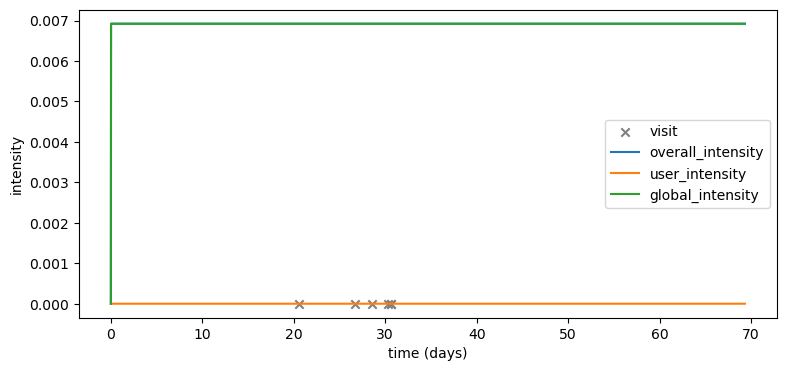

In [21]:
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)